In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from time import sleep as fallasleep
import os, sys

In [2]:
import krakenex
from pykrakenapi import KrakenAPI

In [3]:
color_box = ['#1f77b4','#ff7f0e','#2ca02c','#d62728',
             '#9467bd','#8c564b','#e377c2','#7f7f7f',
             '#bcdb22','#17becf']

In [4]:
api = krakenex.API()
k = KrakenAPI(api)
coins = ["ETH", "BTC", "XRP", "ADA", "DOT"]
gapmin= 1440
coins = [coin+"USD" for coin in coins]
df = {}
colormapper = {}
for _,coin in enumerate(coins):
    data, last = k.get_ohlc_data(coin, interval = gapmin, ascending = True)
    df[coin]=data.drop(['time', 'count'], axis=1)
    colormapper[coin] = color_box[_]
    fallasleep(1)


In [5]:
df_close = pd.DataFrame(columns=coins)
for coin in coins:
    df_close[coin] = df[coin]['close']

In [6]:
df_close.isna().sum()

ETHUSD      0
BTCUSD      0
XRPUSD      0
ADAUSD      0
DOTUSD    272
dtype: int64

In [7]:
df_close = df_close.dropna()
df_close.isna().sum()

ETHUSD    0
BTCUSD    0
XRPUSD    0
ADAUSD    0
DOTUSD    0
dtype: int64

In [8]:
df_close.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-18,422.62,11957.0,0.30292,0.137218,3.1099
2020-08-19,407.57,11757.4,0.28992,0.129678,2.9175
2020-08-20,416.20,11864.6,0.29246,0.134305,2.9090


In [9]:
df_close_diff = df_close.apply(np.log).diff().dropna()
df_close_diff.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-19,-0.036261,-0.016834,-0.043864,-0.056516,-0.063863
2020-08-20,0.020953,0.009076,0.008723,0.035059,-0.002918
2020-08-21,-0.070599,-0.029240,-0.046364,-0.087043,0.056341


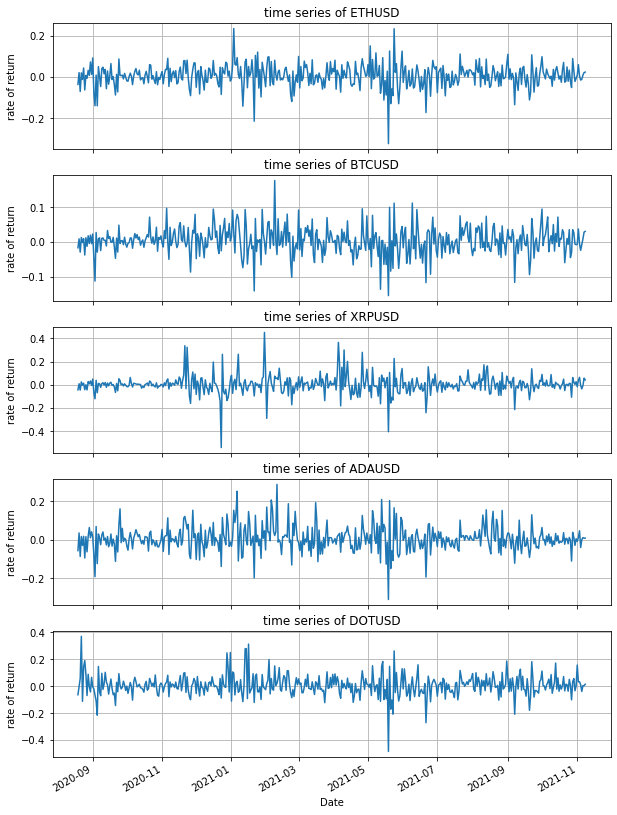

In [10]:
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(len(df_close_diff.columns),1,figsize=(10,15))
for _,col in enumerate(df_close_diff):
    ax[_].plot(df_close_diff.index, df_close_diff[col].values)
    ax[_].set_title(f"time series of {col}")
    ax[_].set_ylabel("rate of return")
    ax[_].set_xlabel("Date")
    ax[_].grid()
fig.autofmt_xdate()
plt.show()

### Mean-Variance Optimization (no cardinality constraint)
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2}x^TQx - r^Tx\\
        &\text{subject to}&& \mathbf{1}^Tx = k\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

In [18]:
Q = df_close_diff.cov().values
r = df_close_diff.mean().values

## Using Gurobi

In [19]:
from gurobipy import *

In [77]:
m = Model("MVO")
x = {}
n = len(Q)
lam = 0.5
k = 2
x = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = 0.5 * lam * (x @ Q @ x) - (1 - lam) * (r @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

for v in m.getVars():
    print('%s: %g' % (v.varName, round(v.x,2)))

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x1b97d111
Model has 15 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 3e-03]
  QObjective range [8e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0026145
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -3.514942e-03, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      -0.0026589   -0.00266  0.00%     -    0s

Explored 0 nodes (8 simplex iterati

## Using Qiskit

### QAOA

In [73]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
from qiskit import Aer
from qiskit_finance.data_providers._base_data_provider import BaseDataProvider
from qiskit.finance.applications.ising import portfolio
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE, QAOA
from qiskit.aqua.components.optimizers import COBYLA

In [94]:
def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, r, Q, lam, k, n)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    states, values, probs = [], [], []
    for i in i_sorted:
        x = index_to_selection(i, n)
        value = portfolio.portfolio_value(x, r, Q, lam, k, n)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))
        states.append(''.join(str(i) for i in x))
        values.append(value)
        probs.append(probability)
    return selection, states, values, probs

def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def selection_to_picks(num_assets, selection):
    purchase = []
    for i in range(num_assets):
        if selection[i] == 1:
            purchase.append(coins[i])
    return purchase

In [100]:
qubitOp, offset = portfolio.get_operator(r, Q, lam, k, n)
backend = Aer.get_backend('statevector_simulator') # You can switch to different backends by providing the name of backend.
seed = 50
cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
qaoa = QAOA(qubitOp, cobyla, 3)
qaoa.random_seed = seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
results= qaoa.run(quantum_instance)
selection, state, values, probabilities = print_result(results)

print(selection_to_picks(n, selection))

/home/ape/anaconda3/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Optimal: selection [1. 0. 0. 1. 0.], value -0.0053

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 1 0]	-0.0053		0.0769
[0 1 0 1 0]	-0.0053		0.0769
[1 1 0 0 0]	-0.0052		0.0769
[0 1 0 0 1]	-0.0044		0.0767
[1 0 0 0 1]	-0.0043		0.0767
[0 0 0 1 1]	-0.0041		0.0766
[1 0 1 0 0]	-0.0012		0.0759
[0 1 1 0 0]	-0.0011		0.0759
[0 0 1 1 0]	-0.0009		0.0758
[0 0 1 0 1]	-0.0001		0.0757
[1 1 0 1 0]	4.9949		0.0171
[1 1 0 0 1]	4.9963		0.0169
[0 1 0 1 1]	4.9963		0.0169
[1 0 0 1 1]	4.9974		0.0166
[1 1 1 0 0]	4.9991		0.0166
[0 1 1 1 0]	4.9994		0.0166
[0 1 1 0 1]	5.0004		0.0164
[1 0 1 1 0]	5.0002		0.0164
[1 0 1 0 1]	5.0014		0.0162
[0 0 1 1 1]	5.0019		0.0162
[0 0 0 1 0]	4.9961		0.0104
[1 0 0 0 0]	4.9961		0.0104
[0 0 0 0 1]	4.9967		0.0104
[0 1 0 0 0]	4.9970		0.0102
[0 0 1 0 0]	5.0002		0.0101
[1 1 1 1 1]	45.0096		0.0066
[1 0 1 1 1]	20.0059		0.0024
[0 1 1 1 1]	20.0040		0.0024
[1 1 1 0 1]	20.0036		0.0024
[1 1 1 1 0]	20.002

/home/ape/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


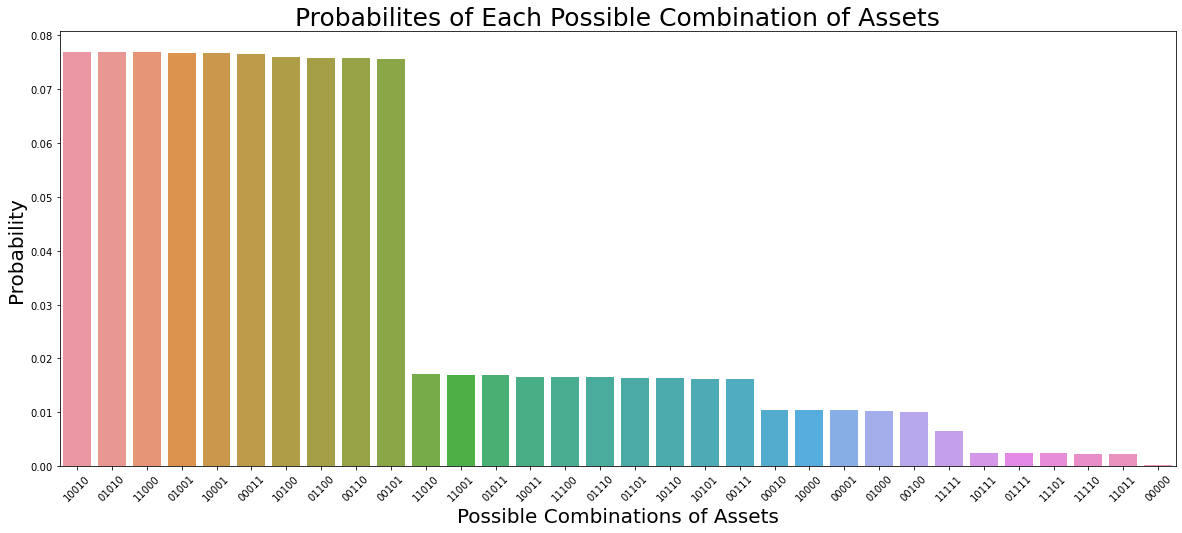

In [101]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(state, probabilities)
for item in optimized_value.get_xticklabels():
    item.set_rotation(45)
plt.title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
plt.xlabel('Possible Combinations of Assets',fontsize =20)
plt.ylabel('Probability',fontsize = 20)
plt.show()

### VQE

In [96]:
backend = Aer.get_backend('statevector_simulator') # You can switch to different backends by providing the name of backend.
seed = 50
cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
result = vqe.run(quantum_instance)
selection, state, values, probabilities = print_result(result)
print(selection_to_picks(n, selection))

Optimal: selection [0. 1. 0. 1. 0.], value -0.0053

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0]	-0.0053		0.3865
[0 1 0 0 1]	-0.0044		0.2815
[1 0 0 0 1]	-0.0043		0.1690
[1 0 0 1 0]	-0.0053		0.1229
[1 1 0 0 0]	-0.0052		0.0282
[0 0 0 1 1]	-0.0041		0.0119
[1 0 0 0 0]	4.9961		0.0000
[0 1 0 1 1]	4.9963		0.0000
[0 0 0 1 0]	4.9961		0.0000
[1 0 0 1 1]	4.9974		0.0000
[0 0 0 0 1]	4.9967		0.0000
[0 1 0 0 0]	4.9970		0.0000
[1 1 0 1 0]	4.9949		0.0000
[0 0 0 0 0]	20.0000		0.0000
[1 1 0 0 1]	4.9963		0.0000
[1 1 0 1 1]	19.9995		0.0000
[0 1 1 1 0]	4.9994		0.0000
[0 1 1 0 0]	-0.0011		0.0000
[1 0 1 1 0]	5.0002		0.0000
[0 1 1 1 1]	20.0040		0.0000
[1 0 1 1 1]	20.0059		0.0000
[1 0 1 0 0]	-0.0012		0.0000
[0 0 1 1 1]	5.0019		0.0000
[1 1 1 1 0]	20.0021		0.0000
[0 0 1 0 1]	-0.0001		0.0000
[1 1 1 0 1]	20.0036		0.0000
[1 0 1 0 1]	5.0014		0.0000
[0 0 1 1 0]	-0.0009		0.0000
[1 1 1 0 0]	4.9991		0.0000
[0 1 1 0 1]	5.00

/home/ape/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


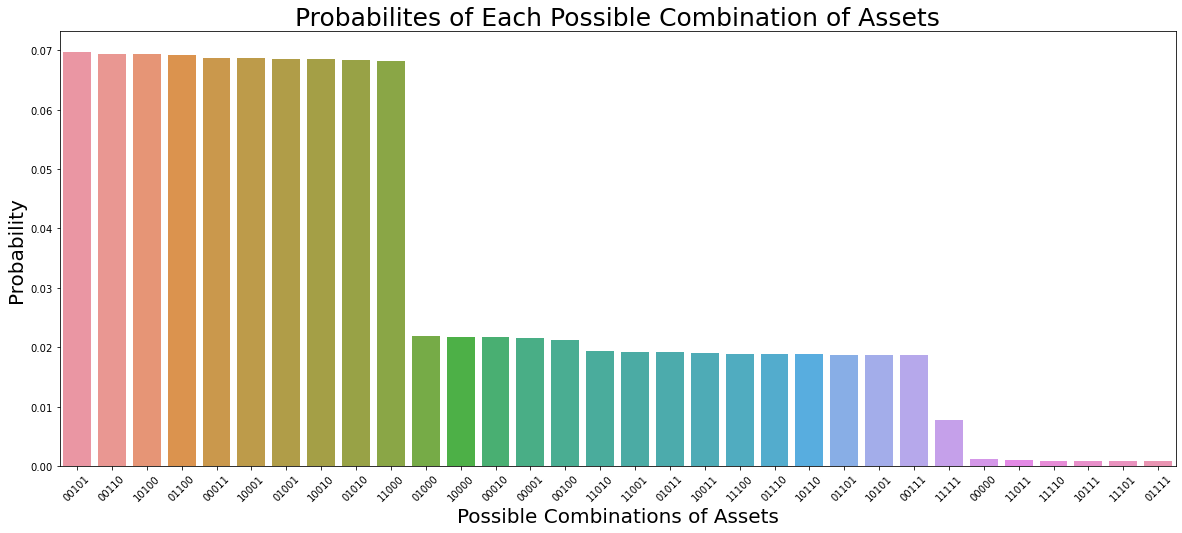

In [99]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(state, probabilities)
for item in optimized_value.get_xticklabels():
    item.set_rotation(45)
plt.title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
plt.xlabel('Possible Combinations of Assets',fontsize =20)
plt.ylabel('Probability',fontsize = 20)
plt.show()

### Circuit Design

### k-medoids clustering for index-tracking
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & -\alpha \cdot x^TDx + \beta \cdot 1^TDx\\
        &\text{subject to}&& \mathbf{1}^Tx = 1\\
        &&& x \in \{0,1\}
\end{aligned}
$$

In [69]:
m = Model("MVO")
x = {}
n = len(Q)
k = 2
beta = 1 / (2 * (k-1))
alpha = 1 / (n-1)
D = df_close_diff.corr()
D = 0.5*(1- D)
D = D.apply(np.sqrt)
D = 1 - (-0.5 * D).apply(np.exp)
D = D.values

x = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = -beta * (x @ D @ x) + alpha * (np.ones(n).dot(D) @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

for v in m.getVars():
    print('%s: %g' % (v.varName, v.x))

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0xb4cd3273
Model has 10 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e-01]
  QObjective range [3e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 0.2192693
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -3.998431e-01, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.39984    0    5    0.21927   -0.39984   282%     -    0s
H    0     0                       0.